# Object detection: Added snow

In [1]:
import re
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
from PIL import Image

from dpemu import runner
from dpemu.dataset_utils import load_coco_val_2017
from dpemu.filters.image import Snow
from dpemu.ml_utils import run_ml_module_using_cli, load_yolov3
from dpemu.nodes import Array, Series
from dpemu.plotting_utils import print_results_by_model, visualize_scores
from dpemu.utils import get_project_root

In [ ]:
def get_data():
    imgs, _, _, img_filenames = load_coco_val_2017()
    return imgs, img_filenames

In [2]:
def get_err_root_node():
    err_node = Array()
    err_root_node = Series(err_node)
    err_node.addfilter(Snow("snowflake_probability", "snowflake_alpha", "snowstorm_alpha"))
    return err_root_node

In [3]:
def get_err_params_list():
    return [{"snowflake_probability": p, "snowflake_alpha": .4, "snowstorm_alpha": 0}
            for p in [10 ** i for i in range(-4, 0)]]

In [4]:
class Preprocessor:

    def run(self, _, imgs, params):
        img_filenames = params["img_filenames"]

        for i, img_arr in enumerate(imgs):
            img = Image.fromarray(img_arr)
            path_to_img = f"{get_project_root()}/tmp/val2017/" + img_filenames[i]
            img.save(path_to_img, "jpeg", quality=100)

        return None, imgs, {}

In [5]:
class YOLOv3Model:

    def run(self, _, imgs, params):
        path_to_yolov3_weights, path_to_yolov3_cfg = load_yolov3()

        cline = f"{get_project_root()}/libs/darknet/darknet detector map {get_project_root()}/data/coco.data \
            {path_to_yolov3_cfg} {path_to_yolov3_weights}"
        out = run_ml_module_using_cli(cline, show_stdout=False)

        match = re.search(r"\(mAP@0.50\) = (\d+\.\d+)", out)
        return {"mAP-50": round(float(match.group(1)), 3)}


class AbstractDetectronModel(ABC):

    def run(self, _, imgs, params):
        path_to_cfg = self.get_path_to_cfg()
        url_to_weights = self.get_url_to_weights()

        cline = f"""{get_project_root()}/libs/Detectron/tools/test_net.py \
            --cfg {path_to_cfg} \
            TEST.WEIGHTS {url_to_weights} \
            NUM_GPUS 1 \
            TEST.DATASETS '("coco_2017_val",)' \
            MODEL.MASK_ON False \
            OUTPUT_DIR {get_project_root()}/tmp \
            DOWNLOAD_CACHE {get_project_root()}/tmp"""
        out = run_ml_module_using_cli(cline, show_stdout=False)

        match = re.search(r"IoU=0.50      \| area=   all \| maxDets=100 ] = (\d+\.\d+)", out)
        return {"mAP-50": round(float(match.group(1)), 3)}

    @abstractmethod
    def get_path_to_cfg(self):
        pass

    @abstractmethod
    def get_url_to_weights(self):
        pass


class FasterRCNNModel(AbstractDetectronModel):

    def get_path_to_cfg(self):
        return f"{get_project_root()}/libs/Detectron/configs/12_2017_baselines/e2e_faster_rcnn_X-101-64x4d-FPN_1x.yaml"

    def get_url_to_weights(self):
        return (
            "https://dl.fbaipublicfiles.com/detectron/35858015/12_2017_baselines/"
            "e2e_faster_rcnn_X-101-64x4d-FPN_1x.yaml.01_40_54.1xc565DE/output/train/"
            "coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl"
        )


class MaskRCNNModel(AbstractDetectronModel):

    def get_path_to_cfg(self):
        return f"{get_project_root()}/libs/Detectron/configs/12_2017_baselines/e2e_mask_rcnn_X-101-64x4d-FPN_1x.yaml"

    def get_url_to_weights(self):
        return (
            "https://dl.fbaipublicfiles.com/detectron/36494496/12_2017_baselines/"
            "e2e_mask_rcnn_X-101-64x4d-FPN_1x.yaml.07_50_11.fkwVtEvg/output/train/"
            "coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl"
        )


class RetinaNetModel(AbstractDetectronModel):

    def get_path_to_cfg(self):
        return f"{get_project_root()}/libs/Detectron/configs/12_2017_baselines/retinanet_X-101-64x4d-FPN_1x.yaml"

    def get_url_to_weights(self):
        return (
            "https://dl.fbaipublicfiles.com/detectron/36768875/12_2017_baselines/"
            "retinanet_X-101-64x4d-FPN_1x.yaml.08_34_37.FSXgMpzP/output/train/"
            "coco_2014_train%3Acoco_2014_valminusminival/retinanet/model_final.pkl"
        )

In [6]:
def get_model_params_dict_list():
    return [
        {"model": FasterRCNNModel, "params_list": [{}]},
        {"model": MaskRCNNModel, "params_list": [{}]},
        {"model": RetinaNetModel, "params_list": [{}]},
        {"model": YOLOv3Model, "params_list": [{}]},
    ]

In [7]:
def visualize(df):
    visualize_scores(
        df, 
        score_names=["mAP-50"], 
        is_higher_score_better=[True], 
        err_param_name="snowflake_probability", 
        title="Object detection with added snow",
        x_log=True
    )
    plt.show()

In [8]:
def main():
    imgs, img_filenames = get_data()

    df = runner.run(
        train_data=None,
        test_data=imgs,
        preproc=Preprocessor,
        preproc_params={"img_filenames": img_filenames},
        err_root_node=get_err_root_node(),
        err_params_list=get_err_params_list(),
        model_params_dict_list=get_model_params_dict_list(),
        n_processes=1
    )

    print_results_by_model(df, dropped_columns=["snowflake_alpha", "snowstorm_alpha"])
    visualize(df)

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [52:45<2:38:17, 3165.81s/it]

 50%|█████     | 2/4 [1:46:02<1:45:49, 3174.95s/it]

 75%|███████▌  | 3/4 [2:44:35<54:36, 3276.48s/it]  

100%|██████████| 4/4 [4:32:27<00:00, 4235.02s/it]


FasterRCNN #1
   mAP-50  snowflake_probability     time_err    time_mod    time_pre
0   0.633                 0.0001   325.687212  776.248342  187.525523
1   0.607                 0.0010   358.006337  777.066054  190.404014
2   0.472                 0.0100   663.940297  776.474450  200.310035
3   0.134                 0.1000  3672.311759  766.583386  196.833806
MaskRCNN #1
   mAP-50  snowflake_probability     time_err    time_mod    time_pre
0   0.638                 0.0001   325.687212  774.348130  187.525523
1   0.615                 0.0010   358.006337  774.845580  190.404014
2   0.481                 0.0100   663.940297  774.726470  200.310035
3   0.139                 0.1000  3672.311759  760.135638  196.833806
RetinaNet #1
   mAP-50  snowflake_probability     time_err     time_mod    time_pre
0   0.591                 0.0001   325.687212  1008.703728  187.525523
1   0.565                 0.0010   358.006337  1008.027457  190.404014
2   0.434                 0.0100   663.940297  1

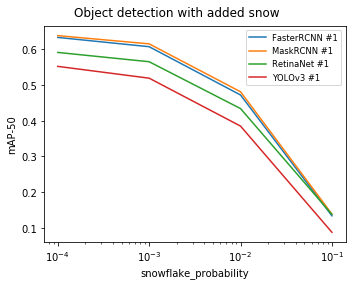

In [9]:
main()

The notebook for this case study can be found [here](https://github.com/dpEmu/dpEmu/blob/master/docs/case_studies/Object_Detection_Added_Snow.ipynb).